### Initialization

In [1]:
# import
import Untitled as da
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

[-3. -1.  0.  0.  0.  5.]


In [2]:
# constants
h = 6.626*10**-34
c = 3.00*10**8
e = 1.60*10**-19
k_B = 1.38*10**-23

T = [294, 77]

In [3]:
# measured data
data, notes, conditions = da.import_data()

Δmono = 0.5 # nm
ΔU = 1 # mV
U_0 = 2 # mV
Δa = 1 # °

a_1 = data[0][0] # °
U_1 = data[0][1] - U_0 # mV
λ_1 = 600 # nm

λ_2 = [768, 905, 1060] # nm
mono_2 = [data[1][0], data[2][0], data[3][0]] # nm
U_2 = [data[1][1] - U_0, data[2][1] - U_0, data[3][1] - U_0] # mV

mono_la = data[6][0] # nm
U_la = [data[6][1] - U_0, data[6][2] - U_0, data[6][3] - U_0] # mV

mono_si = [data[7][0], data[8][0]] # nm
U_si = [data[7][1] - U_0, data[8][1] - U_0] # mV

mono_ga = [data[4][0], data[5][0]] # nm
U_ga = [data[4][1] - U_0, data[5][1] - U_0] # mV

From Data the following files were imported:

varname               filename             shape      conditions                       notes                       

data[0]   :           v44_1.txt           2 x 19          0      ['lambda = 600 nm'];  ['delta = 1°', 'delta = 1mV'
data[1]   :           v44_2a.txt          2 x 31          0      ['lambda = 768 nm'];  ['delta = 0.5nm', 'delta = 1
data[2]   :           v44_2b.txt          2 x 31          0      ['lambda = 905 nm'];  ['delta = 0.5nm', 'delta = 1
data[3]   :           v44_2c.txt          2 x 36          0      ['lambda = 1060 nm'];  ['delta = 0.5nm', 'delta = 
data[4]   :           v44_gaas.txt        2 x 52          0      ['delta = 0.5nm' 'delta = 1mV'];  ['mono [nm]' 'Ga
data[5]   :           v44_gaas_cooled.txt 2 x 61          0      ['delta = 0.5nm' 'delta = 1mV'];  ['mono [nm]' 'Ga
data[6]   :           v44_lamp.txt        4 x 41          0      ['delta = 0.5nm' 'delta = 1mV' 'delta = 1mV' 'delt
data[7]   :           v44

In [4]:
# theoretical functions
def lin(x, a, b):
    return a*x + b

def gauss(x, a, μ, σ):
    return a/np.sqrt(2*np.pi*σ**2)*np.exp( -(x - μ)**2/(2*σ**2))

def dgauss_dx(x, a, μ, σ):
    return -(x - μ)/(2*σ**2)*gauss(x, a, μ, σ)

def α(I, I0):
    return -np.log(I/I0)

def Δα(I, ΔI, I0, ΔI0):
    return np.sqrt((ΔI/I)**2 + (ΔI0/I0)**2)

### Linearity of the photo diode

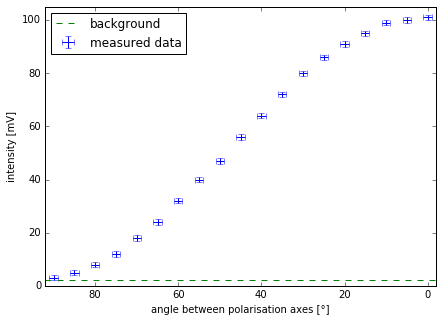

In [5]:
fig,ax = plt.subplots(figsize=(7,5))

ax.errorbar(a_1, U_1 + U_0, xerr=Δa, yerr=ΔU, fmt='none', label='measured data')
ax.axhline(U_0, ls='--', c='g', label='background')
ax.set_xlim(-2, 92)
ax.set_ylim(0, 105)
ax.invert_xaxis()
ax.legend(loc=0)
ax.set_xlabel('angle between polarisation axes [°]')
ax.set_ylabel('intensity [mV]')
#fig.savefig('angle_plot.pdf')

In [6]:
sin2 = np.sin((a_1 - 90)*np.pi/180)**2
Δsin2 = 2*np.sin((a_1 - 90)*np.pi/180)*np.cos((a_1 - 90)*np.pi/180)*np.pi/180*Δa

opt_1, cov_1 = curve_fit(lin, sin2, U_1)
sigma_1 = np.sqrt(ΔU**2 + (opt_1[0]*Δsin2)**2)

opt_1, cov_1 = curve_fit(lin, sin2, U_1, sigma = sigma_1, absolute_sigma = True)
err_1 = np.sqrt(np.diag(cov_1))
χ2_1 = sum((U_1 - lin(sin2, *opt_1))**2/sigma_1**2)/(len(U_1) - len(opt_1))

opt_1, err_1, χ2_1

(array([ 96.76710595,   3.30739093]),
 array([ 0.7514907 ,  0.48922427]),
 1.2583523040203974)

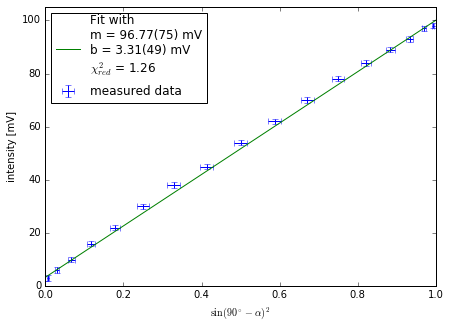

In [7]:
fig,ax = plt.subplots(figsize=(7,5))

ax.errorbar(sin2, U_1, xerr=Δsin2, yerr=ΔU, fmt='none', label='measured data')
x = np.linspace(0, 1, 100)
ax.plot(x, lin(x, *opt_1), label="""Fit with
m = %.2f(%.f) mV
b = %.2f(%.f) mV
$\chi^2_{red}$ = %.2f"""%(opt_1[0], 10**2*err_1[0], opt_1[1], 10**2*err_1[1], χ2_1))
ax.set_ylim(0, 105)
#ax.invert_xaxis()
ax.legend(loc=0)
ax.set_xlabel(r'$\sin(90^\circ-\alpha)^2$')
ax.set_ylabel('intensity [mV]')
#fig.savefig('angle_fit.pdf')

### Calibration of the monochromator

In [8]:
opt_2 = np.zeros([3,3])
cov_2 = np.zeros([3,3,3])
err_2 = np.zeros([3,3])
χ2_2 = np.zeros(3)

for i in [0,1,2]:
    opt_2[i], cov_2[i] = curve_fit(gauss, mono_2[i], U_2[i], p0 = [200, λ_2[i], 30])
    sigma_2 = np.sqrt(ΔU**2 + (Δmono*dgauss_dx(mono_2[i], *opt_2[i]))**2)
    #print(sigma_2)
    opt_2[i], cov_2[i] = curve_fit(gauss, mono_2[i], U_2[i], sigma = sigma_2, p0 = [200, λ_2[i], 30],
                                   absolute_sigma = True)
    err_2[i] = np.sqrt(np.diag(cov_2[i]))
    χ2_2[i] = sum((U_2[i] - gauss(mono_2[i], *opt_2[i]))**2/sigma_2**2)/(len(U_2[i]) - len(opt_2[i]))

opt_2, err_2, χ2_2

(array([[  5.60961063e+03,   7.64849639e+02,  -5.44416162e+00],
        [  5.47213145e+03,   9.00777735e+02,  -6.33756092e+00],
        [  1.05397062e+03,   1.07183738e+03,   6.91998133e+00]]),
 array([[  3.27610449e+01,   4.99920412e-02,   3.08143966e-02],
        [  3.19688422e+01,   5.44660324e-02,   3.68388235e-02],
        [  8.92899441e+00,   7.00618056e-02,   6.41119997e-02]]),
 array([ 6.00477721,  4.89535785,  3.89212642]))

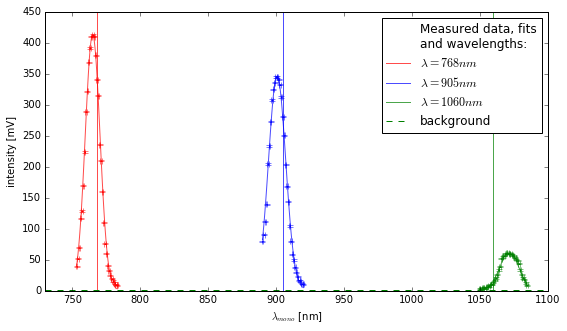

In [9]:
fig,ax = plt.subplots(figsize=(9,5))

colors = ['r', 'b', 'g']
ax.plot(0,0,alpha=0, label='Measured data, fits\nand wavelengths:')
for i in [0,1,2]:
    ax.errorbar(mono_2[i], U_2[i] + U_0, xerr=Δmono, yerr=ΔU, ecolor=colors[i], fmt='none')
    x = np.linspace(min(mono_2[i]), max(mono_2[i]), 100)
    ax.plot(x, gauss(x, *opt_2[i]) + U_0, c=colors[i], label='$\lambda = %d nm$'%λ_2[i], alpha=0.7)
    ax.axvline(λ_2[i], color=colors[i], alpha=0.7)
ax.axhline(U_0, ls='--', c='g', label='background')
ax.set_xlim(730, 1100)
ax.legend(loc=0)
ax.set_xlabel('$\lambda_{mono}$ [nm]')
ax.set_ylabel('intensity [mV]')
#fig.savefig('mono_fits.pdf')

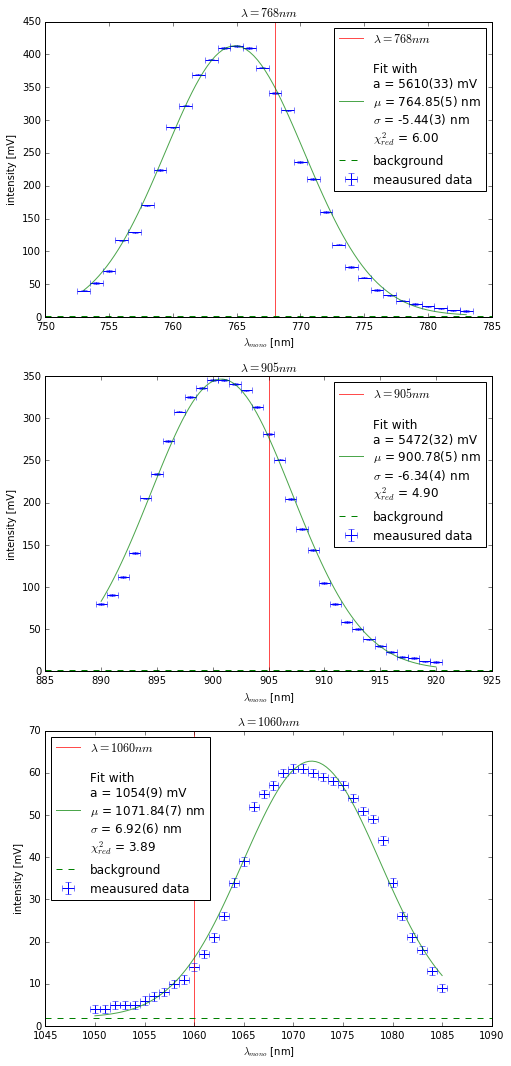

In [10]:
fig,ax = plt.subplots(3,1,figsize=(8,18))

for i in [0,1,2]:
    ax[i].axvline(λ_2[i], color='r', alpha=0.7, label='$\lambda = %d nm$'%λ_2[i])
    ax[i].errorbar(mono_2[i], U_2[i] + U_0, xerr=Δmono, yerr=ΔU, ecolor='b',
                fmt='none', label='meausured data')
    x = np.linspace(min(mono_2[i]), max(mono_2[i]), 100)
    ax[i].plot(x, gauss(x, *opt_2[i]) + U_0, c='g', alpha=0.7, label="""
Fit with
a = %.f(%.f) mV
$\mu$ = %.2f(%.f) nm
$\sigma$ = %.2f(%.f) nm
$\chi^2_{red}$ = %.2f"""%(opt_2[i][0],
                          10**0*err_2[i][0], opt_2[i][1], 10**2*err_2[i][1], opt_2[i][2], 10**2*err_2[i][2], χ2_2[i]))
    ax[i].axhline(U_0, ls='--', c='g', label='background')
    ax[i].set_title('$\lambda = %d nm$'%λ_2[i])
    ax[i].legend(loc=0)
    ax[i].set_xlabel('$\lambda_{mono}$ [nm]')
    ax[i].set_ylabel('intensity [mV]')
#fig.savefig('mono_single_fits.pdf')

In [11]:
λ_mono = np.rollaxis(opt_2,1)[1]
Δλ_mono = np.rollaxis(err_2,1)[1]

opt_3, cov_3 = curve_fit(lin, λ_2, λ_mono, sigma = Δλ_mono, absolute_sigma = True)
err_3 = np.sqrt(np.diag(cov_3))
χ2_3 = sum((λ_mono - lin(λ_2, *opt_3))**2/Δλ_mono**2)/(len(λ_mono) - len(opt_3))

opt_3, err_3, χ2_3

C:\Users\Niklas\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(array([  1.0456246 , -40.45276444]),
 array([ 0.00029074,  0.25800409]),
 1556276.4995859112)

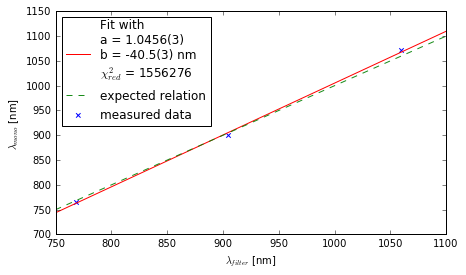

In [12]:
# plots
fig,ax = plt.subplots(figsize=(7,4))

ax.scatter(λ_2, λ_mono, marker='x', label='measured data')
x = np.linspace(750,1100,100)
ax.plot(x, lin(x, *opt_3), c='red', label="""Fit with
a = %.4f(%.f)
b = %.1f(%.f) nm
$\chi^2_{red}$ = %.f"""%(opt_3[0], 10**4*err_3[0], opt_3[1], 10**1*err_3[1], χ2_3))
ax.plot(x, lin(x, 1, 0), ls='--', alpha=0.9, c='g', label='expected relation')
ax.legend(loc=0)
ax.set_xlim(min(x), max(x))
ax.set_ylabel('$\lambda_{mono}$ [nm]')
ax.set_xlabel('$\lambda_{filter}$ [nm]')
#fig.savefig('mono_lin_fit.pdf')

The errors are too small to see.

### Lamp spectra

In [13]:
def λ_corr(λ):
    return lin(λ, *opt_3)

def Δλ_corr(λ):
    return np.sqrt((Δmono*opt_3[0])**2 + (λ*err_3[0])**2 + (err_3[1])**2)

def U_lamp(λ,per):
    if sum(per)!=1:
        raise ValueError('Give the percentage of the three lamps')
    λ = np.array(λ)
    array = per[0]*U_la[0] + per[1]*U_la[1] + per[2]*U_la[2]
    return (λ/20 - λ//20)*array[np.ceil(λ/20).astype(int) - 20] + (1 - λ/20 + λ//20)*array[np.floor(λ/20).astype(int) - 20]

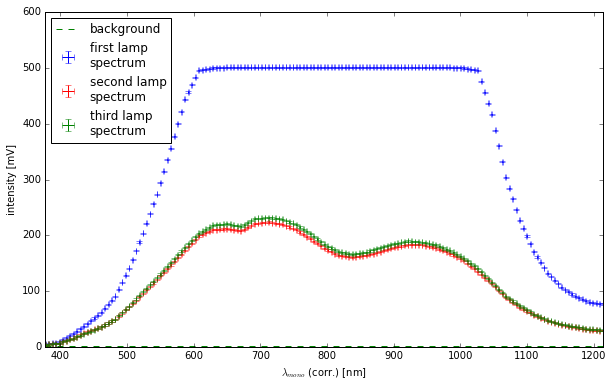

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

x = np.linspace(400, 1200, 161)
#ax[0][0].plot(λ_corr(x), U_lamp(x, [1, 0, 0]), label='first measurement')
#ax[0][0].plot(λ_corr(x), U_lamp(x, [0, 1, 0]), label='second measurement')
#ax[0][0].plot(λ_corr(x), U_lamp(x, [0, 0, 1]), label='third measurement')

ax.errorbar(λ_corr(x), U_lamp(x, [1, 0, 0]) + U_0, xerr=Δλ_corr(x), yerr=ΔU, ecolor='b', fmt='none',
               label='first lamp\nspectrum')
ax.axhline(U_0, ls='--', c='g', label='background')

ax.errorbar(λ_corr(x), U_lamp(x, [0, 1, 0]) + U_0, xerr=Δλ_corr(x), yerr=ΔU, ecolor='r', fmt='none',
               label='second lamp\nspectrum')
#ax[1].axhline(U_0, ls='--', c='g', label='background')

ax.errorbar(λ_corr(x), U_lamp(x, [0, 0, 1]) + U_0, xerr=Δλ_corr(x), yerr=ΔU, ecolor='g', fmt='none',
               label='third lamp\nspectrum')
#ax[2].axhline(U_0, ls='--', c='g', label='background')

#for i in [0,1,2]:
ax.set_xlim(min(λ_corr(x)), max(λ_corr(x)))
ax.legend(loc=0)
ax.set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax.set_ylabel('intensity [mV]')
#fig.savefig('lamp_spectra.pdf')

In [15]:
per = [[0.3, 0.7, 0], [0, 0.3, 0.7]]

### Band gap in GaAs

In [16]:
opt_ga = np.zeros([2,2,2])
cov_ga = np.zeros([2,2,2,2])
err_ga = np.zeros([2,2,2])
χ2_ga = np.zeros([2,2])
bor_ga = [[[26, 28], [28, 44]], [[23, 26], [28, 53]]]
for i in [0,1]:
    for j in [0,1]:
        opt_ga[i][j], cov_ga[i][j] = curve_fit(lin, λ_corr(mono_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]]),
                                         α(U_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]],
                                           U_lamp(mono_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]], per[i])))#,
                                #         sigma = Δα(U_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]], ΔU,
                                 #                   U_lamp(mono_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]], per[i]), ΔU),
                                  #       absolute_sigma = True)
        err_ga[i][j] = np.sqrt(np.diag(cov_ga[i][j]))
        χ2_ga[i][j] = sum((α(U_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]],
                          U_lamp(mono_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]], per[i]))
                        - lin(λ_corr(mono_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]]), *opt_ga[i][j]))**2
                       /Δα(U_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]], ΔU,
                           U_lamp(mono_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]], per[i]),
                           ΔU)**2)/(len(λ_corr(mono_ga[i][bor_ga[i][j][0]:bor_ga[i][j][1]])) - len(opt_ga[i][j]))

# should be named intersection
xintercept1 = (opt_ga[0][0][1] - opt_ga[0][1][1])/(opt_ga[0][1][0] - opt_ga[0][0][0])
yintercept1 = lin(xintercept1, *opt_ga[0][0])
xintercept2 = (opt_ga[1][0][1] - opt_ga[1][1][1])/(opt_ga[1][1][0] - opt_ga[1][0][0])
yintercept2 = lin(xintercept2, *opt_ga[1][0])
Δxintercept1 = -Δα(U_ga[0][26], ΔU, U_lamp(mono_ga[0][26], per[i]), ΔU)/opt_ga[0][0][0]
Δxintercept2 = -Δα(U_ga[1][23], ΔU, U_lamp(mono_ga[1][23], per[i]), ΔU)/opt_ga[1][0][0]

opt_ga, err_ga, χ2_ga, xintercept1, yintercept1, xintercept2, yintercept2, Δxintercept1, Δxintercept2

C:\Users\Niklas\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Niklas\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: divide by zero encountered in double_scalars


(array([[[ -1.31599254e-01,   1.23438042e+02],
         [ -7.39791262e-04,   5.29171045e+00]],
 
        [[ -1.85017630e-01,   1.59973976e+02],
         [ -6.02318828e-04,   3.29663249e+00]]]),
 array([[[             inf,              inf],
         [  9.41773149e-04,   9.03787723e-01]],
 
        [[  4.56439655e-02,   3.84829215e+01],
         [  2.08035263e-04,   1.94542833e-01]]]),
 array([[        inf,  0.12559709],
        [ 2.16151194,  0.29003819]]),
 902.84897163579171,
 4.6237906670803852,
 849.58967333668841,
 2.7849086291711842,
 7.5989453608986643,
 5.4049926749935917)

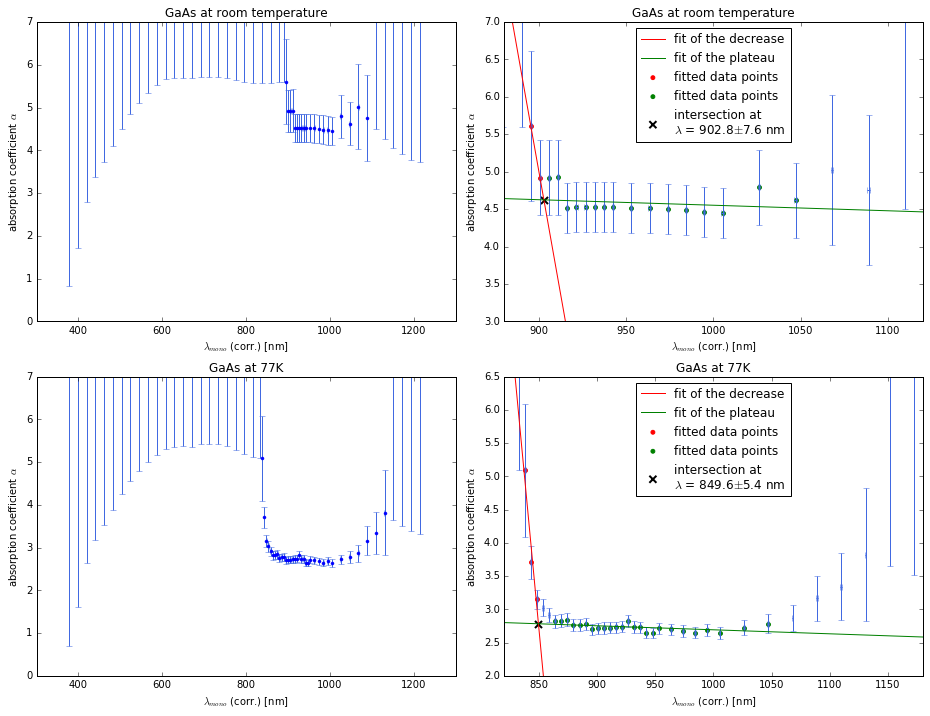

In [17]:
fig,ax = plt.subplots(2, 2, figsize=(13,10))

y = α([ max(10**-3, U_ga[0][i]) for i in range(len(U_ga[0])) ], U_lamp(mono_ga[0], per[0]))

yerr = [α(10**-3, U_lamp(mono_ga[0][i], per[0])) - α(1, U_lamp(mono_ga[0][i], per[0]))
        if 10**-3 > U_ga[0][i]
        else Δα(U_ga[0][i], ΔU, U_lamp(mono_ga[0][i], per[0]), ΔU)
        for i in range(len(U_ga[0]))]

ax[0][0].errorbar(λ_corr(mono_ga[0]), y, xerr = Δλ_corr(mono_ga[0]), yerr=yerr, color='b', ecolor='royalblue', fmt='.')
ax[0][0].set_ylim(0,7)
ax[0][0].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[0][0].set_ylabel(r'absorption coefficient $\alpha$')
ax[0][0].set_title('GaAs at room temperature')

x = np.linspace(860,1120,20)
ax[0][1].errorbar(λ_corr(mono_ga[0]), y, xerr = Δλ_corr(mono_ga[0]), yerr=yerr, color='b', ecolor='royalblue',
                  fmt='none')
ax[0][1].scatter(λ_corr(mono_ga[0][bor_ga[0][0][0]:bor_ga[0][0][1]]), y[bor_ga[0][0][0]:bor_ga[0][0][1]],
                edgecolor='r', c='r', s=15, label='fitted data points')
ax[0][1].plot(x, lin(x, *opt_ga[0][0]), c='r', label='fit of the decrease')
ax[0][1].scatter(λ_corr(mono_ga[0][bor_ga[0][1][0]:bor_ga[0][1][1]]), y[bor_ga[0][1][0]:bor_ga[0][1][1]],
                edgecolor='g', c='g', s=15, label='fitted data points')
ax[0][1].plot(x, lin(x, *opt_ga[0][1]), c='g', label='fit of the plateau')
ax[0][1].set_ylim(3,7)
ax[0][1].set_xlim(880,1120)
ax[0][1].scatter(xintercept1, yintercept1, marker='x', c='k', s=50, lw=2, label="""intersection at
$\lambda$ = %.1f$\pm$%.1f nm"""%(xintercept1, Δxintercept1))
ax[0][1].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[0][1].set_ylabel(r'absorption coefficient $\alpha$')
ax[0][1].legend(loc=0)
ax[0][1].set_title('GaAs at room temperature')


y = α([ max(10**-3, U_ga[1][i]) for i in range(len(U_ga[1])) ], U_lamp(mono_ga[1], per[1]))

yerr = [α(10**-3, U_lamp(mono_ga[1][i], per[1])) - α(1, U_lamp(mono_ga[1][i], per[1]))
        if 10**-3 > U_ga[1][i]
        else Δα(U_ga[1][i], ΔU, U_lamp(mono_ga[1][i], per[1]), ΔU)
        for i in range(len(U_ga[1]))]

ax[1][0].errorbar(λ_corr(mono_ga[1]), y, xerr = Δλ_corr(mono_ga[1]), yerr=yerr, color='b', ecolor='royalblue', fmt='.')
ax[1][0].set_ylim(0,7)
ax[1][0].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[1][0].set_ylabel(r'absorption coefficient $\alpha$')
ax[1][0].set_title('GaAs at 77K')


x = np.linspace(820,1180,20)
ax[1][1].errorbar(λ_corr(mono_ga[1]), y, xerr = Δλ_corr(mono_ga[1]), yerr=yerr, color='b', ecolor='royalblue',
                  fmt='none')
ax[1][1].scatter(λ_corr(mono_ga[1][bor_ga[1][0][0]:bor_ga[1][0][1]]), y[bor_ga[1][0][0]:bor_ga[1][0][1]],
                edgecolor='r', c='r', s=15, label='fitted data points')
ax[1][1].plot(x, lin(x, *opt_ga[1][0]), c='r', label='fit of the decrease')
ax[1][1].scatter(λ_corr(mono_ga[1][bor_ga[1][1][0]:bor_ga[1][1][1]]), y[bor_ga[1][1][0]:bor_ga[1][1][1]],
                 edgecolor='g', c='g', s=15, label='fitted data points')
ax[1][1].plot(x, lin(x, *opt_ga[1][1]), c='g', label='fit of the plateau')
ax[1][1].set_ylim(2,6.5)
ax[1][1].set_xlim(820,1180)
ax[1][1].scatter(xintercept2, yintercept2, marker='x', c='k', s=50, lw=2, label="""intersection at
$\lambda$ = %.1f$\pm$%.1f nm"""%(xintercept2, Δxintercept2))
ax[1][1].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[1][1].set_ylabel(r'absorption coefficient $\alpha$')
ax[1][1].legend(loc=0)
ax[1][1].set_title('GaAs at 77K')
fig.tight_layout()
#fig.savefig('GaAs.pdf')

In [18]:
E_room = h*c/xintercept1/e*10**9 # in eV
ΔE_room = E_room*Δxintercept1/xintercept1
E_cool = h*c/xintercept2/e*10**9 # in eV
ΔE_cool = E_cool*Δxintercept2/xintercept2
E_room, ΔE_room, E_cool, ΔE_cool

(1.3760607133982234,
 0.011581793304196753,
 1.4623235651166542,
 0.0093031358619089198)

### Band gap in Si

Das erste wäre richtig spukt aber nen riesigen Fehler aus, da Eg und Ep anscheinend zu stark korrelieren oder so, habs mal mit ner anderen Methode von curve_fit probiert, da kriegst du hohe negative Werte für Eg raus und der Plot sieht noch genauso gut aus.
Das zweite ist ne krasse Näherung, gibt dafür aber nen ordentlichen Fehler zurück, allerdings ist glaube ich Ep viel zu hoch...

In [19]:
"def ind1(λ, a, Eg, Ep, d):\n",
    "    E = h*c/np.array(λ)/e*10**9\n",
    "    return a*((E - Eg + Ep)**2/(np.exp(Ep/(e*k_B*T[0])) - 1) + (E - Eg - Ep)**2/(1 - np.exp(Ep/(-e*k_B*T[0])))) + d##\n",
    "\n",
    "def ind2(λ, a, Eg, Ep, d):\n",
    "    E = h*c/np.array(λ)/e*10**9\n",
    "    return a*((E - Eg + Ep)**2/(np.exp(Ep/(e*k_B*T[1])) - 1) + (E - Eg - Ep)**2/(1 - np.exp(Ep/(-e*k_B*T[1])))) + d\n",
    "\n",
    "#def ind1(λ, a, Eg, Ep, d):\n",
    "#    E = h*c/np.array(λ)/e*10**9\n",
    "#    return a*((E - Eg + Ep)**2/100 + (E - Eg - Ep)**2/100) + d\n",
    "\n",
    "#def ind2(λ, a, Eg, Ep, d):\n",
    "#    E = h*c/np.array(λ)/e*10**9\n",
    "#    return a*((E - Eg + Ep)**2/100 + (E - Eg - Ep)**2/100) + d"

IndentationError: unexpected indent (<ipython-input-19-566d6b909d40>, line 2)

In [20]:
def ind1(λ, a, Eg, Ep, d):
    E = h*c/np.array(λ)/e*10**9
    return a*((E - Eg + Ep)**2/(np.exp(Ep/(e*k_B*T[0])) - 1) + (E - Eg - Ep)**2/(1 - np.exp(-Ep/(e*k_B*T[0])))) + d

def ind2(λ, a, Eg, Ep, d):
    E = h*c/np.array(λ)/e*10**9
    return a*((E - Eg + Ep)**2/(np.exp(Ep/(e*k_B*T[1])) - 1) + (E - Eg - Ep)**2/(1 - np.exp(-Ep/(e*k_B*T[1])))) + d

#def ind1(λ, a, b, d):
#    E = h*c/np.array(λ)/e*10**9
#    return a*((E - b)**2 + d)

#def ind2(λ, a, b, d):
#    E = h*c/np.array(λ)/e*10**9
#    return a*((E - b)**2 + d)

In [21]:
opt_si = np.zeros([2,4])
cov_si = np.zeros([2,4,4])
err_si = np.zeros([2,4])
χ2_si = np.zeros(2)
bor_si = [[31, 51], [29, 56]]

i = 0
opt_si[i], cov_si[i] = curve_fit(ind1, λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]]),
                                         α(U_si[i][bor_si[i][0]:bor_si[i][1]],
                                           U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i])), 
                                    p0=[100, 1, 10**-3, 1],# bounds=([100,1,10**-5,0],[500,1.4,10**-3,5]),
                                         sigma = Δα(U_si[i][bor_si[i][0]:bor_si[i][1]], ΔU,
                                                    U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]), ΔU),
                                 absolute_sigma = True)
err_si[i] = np.sqrt(np.diag(cov_si[i]))
χ2_si[i] = sum((α(U_si[i][bor_si[i][0]:bor_si[i][1]],
                          U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]))
                        - ind1(λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]]), *opt_si[i]))**2
                       /Δα(U_si[i][bor_si[i][0]:bor_si[i][1]], ΔU,
                           U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]),
                           ΔU)**2)/(len(λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]])) - len(opt_si[i]))

i = 1
opt_si[i], cov_si[i] = curve_fit(ind2, λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]]),
                                         α(U_si[i][bor_si[i][0]:bor_si[i][1]],
                                           U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i])), 
                                    p0=[100, 1, 10**-3, 1],
                                         sigma = Δα(U_si[i][bor_si[i][0]:bor_si[i][1]], ΔU,
                                                    U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]), ΔU),
                                 absolute_sigma = True)
err_si[i] = np.sqrt(np.diag(cov_si[i]))
χ2_si[i] = sum((α(U_si[i][bor_si[i][0]:bor_si[i][1]],
                          U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]))
                        - ind2(λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]]), *opt_si[i]))**2
                       /Δα(U_si[i][bor_si[i][0]:bor_si[i][1]], ΔU,
                           U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]),
                           ΔU)**2)/(len(λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]])) - len(opt_si[i]))


opt_si, err_si, χ2_si#, cov_si"

C:\Users\Niklas\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
C:\Users\Niklas\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: overflow encountered in exp


(array([[  2.54188126e+02,   1.04062409e+00,   9.00537295e-02,
           3.34586060e+00],
        [  1.88518886e+02,   1.12968654e+00,   4.49825024e-02,
           2.37820846e+00]]),
 array([[  7.52260049e+01,   3.66013148e+05,   3.66013151e+05,
           1.33806552e+00],
        [  1.99744819e+01,   1.22133491e+05,   1.22133490e+05,
           3.93950391e-01]]),
 array([ 0.10753163,  0.25840103]))

In [23]:
# correlation

for k in [0,1]:   
    for i in [0,1,2,3]:
        for j in [0,1,2,3]:
            print('row: %d, col: %d'%(i,j))
            print(cov_si[k][i][j]/np.sqrt(cov_si[k][i][i]*cov_si[k][j][j]))

row: 0, col: 0
1.0
row: 0, col: 1
-0.146115020568
row: 0, col: 2
0.146115038718
row: 0, col: 3
0.125431279022
row: 1, col: 0
-0.146115041495
row: 1, col: 1
1.0
row: 1, col: 2
-1.0
row: 1, col: 3
-0.996291941681
row: 2, col: 0
0.146115059646
row: 2, col: 1
-1.0
row: 2, col: 2
1.0
row: 2, col: 3
0.996291942167
row: 3, col: 0
0.125431299979
row: 3, col: 1
-0.996291942413
row: 3, col: 2
0.996291942899
row: 3, col: 3
1.0
row: 0, col: 0
1.0
row: 0, col: 1
0.329160146275
row: 0, col: 2
-0.329160131259
row: 0, col: 3
-0.355553130507
row: 1, col: 0
0.329160150496
row: 1, col: 1
1.0
row: 1, col: 2
-1.0
row: 1, col: 3
-0.994610222658
row: 2, col: 0
-0.32916013548
row: 2, col: 1
-1.0
row: 2, col: 2
1.0
row: 2, col: 3
0.994610223548
row: 3, col: 0
-0.355553134807
row: 3, col: 1
-0.994610222969
row: 3, col: 2
0.99461022386
row: 3, col: 3
1.0


In [ ]:
#opt_si = np.zeros([2,4])
#cov_si = np.zeros([2,4,4])
#err_si = np.zeros([2,4])
#χ2_si = np.zeros(2)
#bor_si = [[31, 51], [29, 56]]

#i = 0
#opt_si[i], cov_si[i] = curve_fit(ind1, λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]]),
#                                         α(U_si[i][bor_si[i][0]:bor_si[i][1]],
#                                           U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i])), 
#                                    p0=[100, 1, 10**-3, 3],# bounds=([100,1,10**-5,0],[500,1.4,10**-3,5]),
#                                         sigma = Δα(U_si[i][bor_si[i][0]:bor_si[i][1]], ΔU,
#                                                    U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]), ΔU),
#                                 absolute_sigma = True)
#err_si[i] = np.sqrt(np.diag(cov_si[i]))
#χ2_si[i] = sum((α(U_si[i][bor_si[i][0]:bor_si[i][1]],
#                          U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]))
#                        - ind1(λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]]), *opt_si[i]))**2
#                       /Δα(U_si[i][bor_si[i][0]:bor_si[i][1]], ΔU,
#                           U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]),
#                           ΔU)**2)/(len(λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]])) - len(opt_si[i]))

#i = 1
#opt_si[i], cov_si[i] = curve_fit(ind2, λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]]),
#                                         α(U_si[i][bor_si[i][0]:bor_si[i][1]],
#                                           U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i])), 
#                                    p0=[100, 1, 10**-3, 3],
#                                         sigma = Δα(U_si[i][bor_si[i][0]:bor_si[i][1]], ΔU,
#                                                    U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]), ΔU),
#                                 absolute_sigma = True)
#err_si[i] = np.sqrt(np.diag(cov_si[i]))
#χ2_si[i] = sum((α(U_si[i][bor_si[i][0]:bor_si[i][1]],
#                          U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]))
#                        - ind2(λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]]), *opt_si[i]))**2
#                       /Δα(U_si[i][bor_si[i][0]:bor_si[i][1]], ΔU,
#                           U_lamp(mono_si[i][bor_si[i][0]:bor_si[i][1]], per[i]),
#                           ΔU)**2)/(len(λ_corr(mono_si[i][bor_si[i][0]:bor_si[i][1]])) - len(opt_si[i]))


#opt_si, err_si, χ2_si#, cov_si

In [ ]:
fig,ax = plt.subplots(2, 2, figsize=(13,10))


y = α([ max(10**-3, U_si[0][i]) for i in range(len(U_si[0])) ], U_lamp(mono_si[0], per[0]))

yerr = [α(10**-3, U_lamp(mono_si[0][i], per[0])) - α(1, U_lamp(mono_si[0][i], per[0]))
        if 10**-3 > U_si[0][i]
        else Δα(U_si[0][i], ΔU, U_lamp(mono_si[0][i], per[0]), ΔU)
        for i in range(len(U_si[0]))]

ax[0][0].errorbar(λ_corr(mono_si[0]), y, xerr = Δλ_corr(mono_si[0]), yerr=yerr, color='b', ecolor='royalblue', fmt='.')
ax[0][0].set_ylim(0,7)
ax[0][0].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[0][0].set_ylabel(r'absorption coefficient $\alpha$')
ax[0][0].set_title('Si at room temperature')

x = np.linspace(990,1180,50)
ax[0][1].errorbar(λ_corr(mono_si[0]), y, xerr = Δλ_corr(mono_si[0]), yerr=yerr, color='b', ecolor='royalblue',
                  fmt='none')
ax[0][1].scatter(λ_corr(mono_si[0][bor_si[0][0]:bor_si[0][1]]), y[bor_si[0][0]:bor_si[0][1]],
                edgecolor='r', c='r', s=15, label='fitted data points')
ax[0][1].plot(x, ind1(x, *opt_si[0]), c='r', label="""Fit with
$B$ = %.f(%.f) eV$^{-2}$
$E_g$ = %.2f(%.f) eV
$E_p$ = %.1f(%.f) meV
$d$ = %.2f(%.f)"""
              %(opt_si[0][0], err_si[0][0], opt_si[0][1], 10**-4*err_si[0][1],
                10**3*opt_si[0][2], 10**-3*err_si[0][2], opt_si[0][3], 10**2*err_si[0][3]))

ax[0][1].set_ylim(2.5,7)
ax[0][1].set_xlim(990,1180)
ax[0][1].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[0][1].set_ylabel(r'absorption coefficient $\alpha$')
ax[0][1].legend(loc=9)
ax[0][1].set_title('Si at room temperature')

y = α([ max(10**-3, U_si[1][i]) for i in range(len(U_si[1])) ], U_lamp(mono_si[1], per[1]))

yerr = [α(10**-3, U_lamp(mono_si[1][i], per[1])) - α(1, U_lamp(mono_si[1][i], per[1]))
        if 10**-3 > U_si[1][i]
        else Δα(U_si[1][i], ΔU, U_lamp(mono_si[1][i], per[1]), ΔU)
        for i in range(len(U_si[1]))]

ax[1][0].errorbar(λ_corr(mono_si[1]), y, xerr = Δλ_corr(mono_si[1]), yerr=yerr, color='b', ecolor='royalblue', fmt='.')
ax[1][0].set_ylim(0,7)
ax[1][0].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[1][0].set_ylabel(r'absorption coefficient $\alpha$')
ax[1][0].set_title('Si at 77K')

#x = np.linspace(0,2200,50)
x = np.linspace(940,1180,50)
ax[1][1].errorbar(λ_corr(mono_si[1]), y, xerr = Δλ_corr(mono_si[1]), yerr=yerr, color='b', ecolor='royalblue',
                  fmt='none')
ax[1][1].scatter(λ_corr(mono_si[1][bor_si[1][0]:bor_si[1][1]]), y[bor_si[1][0]:bor_si[1][1]],
                edgecolor='r', c='r', s=15, label='fitted data points')
ax[1][1].plot(x, ind2(x, *opt_si[1]), c='r', label="""Fit with
$B$ = %.f(%.f) eV$^{-2}$
$E_g$ = %.2f(%.f) eV
$E_p$ = %.1f(%.f) meV
$d$ = %.2f(%.f)"""
              %(opt_si[1][0], err_si[1][0], opt_si[1][1], 10**-4*err_si[1][1],
                10**3*opt_si[1][2], 10**-3*err_si[1][2], opt_si[1][3], 10**2*err_si[1][3]))


ax[1][1].set_ylim(2,7)
#ax[1][1].set_xlim(0,2200)
ax[1][1].set_xlim(940,1180)
ax[1][1].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[1][1].set_ylabel(r'absorption coefficient $\alpha$')
ax[1][1].legend(loc=9)
ax[1][1].set_title('Si at 77K')

fig.tight_layout()
#fig.savefig('Si.pdf')

In [ ]:
# plots
fig,ax = plt.subplots(2,1,figsize=(8,10))

ax[0].axhline(U_0, ls='--', c='g', label='background')
ax[0].errorbar(λ_corr(mono_ga[0]), U_ga[0] + U_0,
               xerr = Δλ_corr(mono_ga[0]), yerr=ΔU, color='g', ecolor='lightgreen', fmt='-', label='T = 295K')
ax[0].errorbar(λ_corr(mono_ga[1]), U_ga[1] + U_0,
               xerr = Δλ_corr(mono_ga[1]), yerr=ΔU, color='b', ecolor='royalblue', fmt='-', label='T = 77K')
ax[0].set_xlim(360,1240)
ax[0].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[0].set_ylabel('intensity [mV]')
ax[0].set_title('GaAs')
ax[0].legend(loc=2)

ax[1].axhline(U_0, ls='--', c='g', label='background')
ax[1].errorbar(λ_corr(mono_si[0]), U_si[0] + U_0,
               xerr = Δλ_corr(mono_si[0]), yerr=ΔU, color='g', ecolor='lightgreen', fmt='-', label='T = 295K')
ax[1].errorbar(λ_corr(mono_si[1]), U_si[1] + U_0,
               xerr = Δλ_corr(mono_si[1]), yerr=ΔU, color='b', ecolor='royalblue', fmt='-', label='T = 77K')
ax[1].set_xlim(360,1240)
ax[1].set_xlabel('$\lambda_{mono}$ (corr.) [nm]')
ax[1].set_ylabel('intensity [mV]')
ax[1].set_title('Si')
ax[1].legend(loc=2)
fig.tight_layout()
#fig.savefig('spectra.pdf')

In [ ]:
np.tanh(0.02/(k_B*T[0]/e))

### Der Rest ist alt

In [ ]:
fig,ax = plt.subplots(figsize=(14,8))

ax.errorbar(mono_ga[0], α(U_ga[0], U_lamp(mono_ga[0], [0.3,0.7,0])), xerr = Δmono)#, fmt='none')
ax.errorbar(mono_ga[1], α(U_ga[1], U_lamp(mono_ga[1], [0,0.3,0.7])), xerr = Δmono)#, fmt='none')
ax.errorbar(mono_si[0], α(U_si[0], U_lamp(mono_si[0], [0.3,0.7,0])), xerr = Δmono)#, fmt='none')
ax.errorbar(mono_si[1], α(U_si[1], U_lamp(mono_si[1], [0,0.3,0.7])), xerr = Δmono)#, fmt='none')

In [ ]:
# plots
fig,ax = plt.subplots(figsize=(14,8))

ax.plot(data[6][0],data[6][1],data[6][0],data[6][2],data[6][0],data[6][3])

In [ ]:
# plots
fig,ax = plt.subplots(2,1,figsize=(14,16))

ax[0].plot(data[7][0],data[7][1],data[4][0],data[4][1])
ax[1].plot(data[8][0],data[8][1],data[5][0],data[5][1])